# 1. Data Loading & Preprocessing

In [1]:
import re
import torch
import warnings
import numpy as np
import pandas as pd
import networkx as nx
import torch.nn.functional as F
import matplotlib.pyplot as plt

from pathlib import Path
from tqdm.auto import tqdm
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.metrics import ndcg_score
from sklearn.metrics import silhouette_score
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

warnings.filterwarnings('ignore')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

2025-08-20 14:02:56.471350: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755698576.708577      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755698576.774036      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Using device: cuda


In [2]:
# Default Settings
agg_method = 'max' # choice: max or avg or no-clustering
model_name = 'all-MiniLM-L6-v2'
weight_tk = 0.6 # title, combined keyword
weight_abs = 0.4 # abstract
min_papers = 4
split_year = 2023
min_papers_for_clustering = 6
k_range = range(2, 6)
k_values = [3, 5, 7, 10, 12, 15, 17, 20]

In [3]:
df = pd.read_csv('/kaggle/input/its-affiliated/cleaned_scopus-its-affiliated-keyword-generator.csv')

df.dropna(subset=['Year'], inplace=True)
df['Year'] = df['Year'].astype(int)
print(f"Dataset: {df.shape[0]} rows, {df.shape[1]} columns")

# force recompute
recompute_embeddings = False
recompute_profiles = False
recompute_similarity = False

# cache dir
cache_dir = Path("/kaggle/working/cache")
train_embed_path = cache_dir / "train_embeddings.pt"
test_embed_path = cache_dir / "test_embeddings.pt"
profile_cache_path = cache_dir / f"author_profiles_{agg_method}.pt"
similarity_cache_path = cache_dir / f"similarity_matrix_{agg_method}.pt"

# Compare all pipelines
compare_all_pipelines = False

# Author testing
target_author_ids = ["57133191900", "35811948800", "57194103723"]

Dataset: 15775 rows, 52 columns


# 2. Author ID Parsing & Mapping

In [4]:
def parse_author_ids(author_id_str):
    if pd.isna(author_id_str):
        return []
    
    all_ids = str(author_id_str).split(';')
    cleaned_ids = []
    
    for aid in all_ids:
        aid_clean = aid.strip()
        if aid_clean:
            cleaned_ids.append(aid_clean)
    
    return cleaned_ids

In [5]:
def create_author_mapping(df):
    author_map = {}
    
    for _, row in df.iterrows():
        author_ids = parse_author_ids(row.get('Author(s) ID', ''))
        full_names_str = str(row.get('Author full names', ''))
        
        author_entries = full_names_str.split(';')
        names_map = {}
        
        for entry in author_entries:
            entry = entry.strip()
            if entry:
                match = re.search(r'(.+?)\s*\((\d+)\)', entry)
                if match:
                    name = match.group(1).strip()
                    author_id = match.group(2).strip()
                    names_map[author_id] = name
        
        for aid in author_ids:
            if aid in names_map:
                author_map[aid] = names_map[aid]
                
    return author_map

In [6]:
author_map = create_author_mapping(df)
print(f"Mapped {len(author_map)} unique authors")

Mapped 21116 unique authors


# 3. Filter Productive Authors & Data Splitting

In [7]:
def create_author_paper_pairs(df):
    author_paper_rows = []
    
    for _, row in tqdm(df.iterrows(), total=df.shape[0], desc="Creating author-paper pairs"):
        author_ids = parse_author_ids(row.get('Author(s) ID', ''))
        
        for author_id in author_ids:
            if author_id in author_map: 
                new_row = row.copy()
                new_row['author_id'] = author_id
                new_row['author_name'] = author_map[author_id]
                author_paper_rows.append(new_row)
    
    return pd.DataFrame(author_paper_rows)

In [8]:
df_author_papers = create_author_paper_pairs(df)
print(f"Author-paper pairs: {len(df_author_papers)}")

Creating author-paper pairs:   0%|          | 0/15775 [00:00<?, ?it/s]

Author-paper pairs: 67247


In [9]:
author_paper_counts = df_author_papers['author_id'].value_counts()
productive_authors = set(author_paper_counts[author_paper_counts >= min_papers].index)

df_productive = df_author_papers[df_author_papers['author_id'].isin(productive_authors)]

df_train = df_productive[df_productive['Year'] < split_year]
df_test = df_productive[df_productive['Year'] >= split_year]

train_authors = set(df_train['author_id'].unique())
valid_authors = train_authors

df_train_final = df_train[df_train['author_id'].isin(valid_authors)].copy()
df_test_final = df_test[df_test['author_id'].isin(valid_authors)].copy()

print(f"Train: {len(df_train_final)}, Test: {len(df_test_final)}, Authors: {len(valid_authors)}")

Train: 30437, Test: 11770, Authors: 2620


# 4. Text Preparation for Filtering

In [10]:
def prepare_title_keywords(row):
    title = str(row.get('Title', '')).strip()
    
    keyword_fields = ['Author Keywords', 'Index Keywords', 'Keywords Generator']
    all_keywords = []
    
    for field in keyword_fields:
        keywords_str = str(row.get(field, '')).strip()
        if keywords_str:
            keywords = keywords_str.split(';')
            for kw in keywords:
                kw_clean = kw.strip()
                if kw_clean:
                    all_keywords.append(kw_clean)
    
    unique_keywords = list(dict.fromkeys(all_keywords))
    keywords_combined = ', '.join(unique_keywords)
    
    return f"{title} {keywords_combined}"

def prepare_abstract(row):
    abstract = str(row.get('Abstract', '')).strip()
    return abstract if abstract else ""

In [11]:
df_train_final['text_title_keywords'] = df_train_final.apply(prepare_title_keywords, axis=1)
df_train_final['text_abstract'] = df_train_final.apply(prepare_abstract, axis=1)

df_test_final['text_title_keywords'] = df_test_final.apply(prepare_title_keywords, axis=1)
df_test_final['text_abstract'] = df_test_final.apply(prepare_abstract, axis=1)

# 5. Dual Embedding Generation

In [12]:
cache_dir.mkdir(parents=True, exist_ok=True)
embedding_model = SentenceTransformer(model_name, device=device)

print(f"Model: {model_name}, Cache: {cache_dir}")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Model: all-MiniLM-L6-v2, Cache: /kaggle/working/cache


In [13]:
def generate_embeddings(texts, batch_size=32):
    embeddings = embedding_model.encode(
        texts,
        batch_size=batch_size, 
        show_progress_bar=True,
        convert_to_tensor=True,
        device=device
    )
    return embeddings

In [14]:
if not recompute_embeddings and train_embed_path.exists():
    train_embeddings = torch.load(train_embed_path)
    print(f"Loaded train embeddings from cache")
else:
    print("Generating train embeddings")
    train_texts_tk = df_train_final['text_title_keywords'].tolist()
    train_texts_abs = df_train_final['text_abstract'].tolist()
    
    train_embed_tk = generate_embeddings(train_texts_tk)
    train_embed_abs = generate_embeddings(train_texts_abs)
    
    train_embeddings = {
        'author_ids': df_train_final['author_id'].tolist(),
        'paper_indices': df_train_final.index.tolist(),
        'embed_title_keywords': train_embed_tk.cpu(),
        'embed_abstract': train_embed_abs.cpu()
    }
    
    torch.save(train_embeddings, train_embed_path)

Loaded train embeddings from cache


In [15]:
if not recompute_embeddings and test_embed_path.exists():
    test_embeddings = torch.load(test_embed_path)
    print(f"Loaded test embeddings from cache")
else:
    print("Generating test embeddings")
    test_texts_tk = df_test_final['text_title_keywords'].tolist()
    test_texts_abs = df_test_final['text_abstract'].tolist()
    
    test_embed_tk = generate_embeddings(test_texts_tk)
    test_embed_abs = generate_embeddings(test_texts_abs)
    
    test_embeddings = {
        'author_ids': df_test_final['author_id'].tolist(),
        'paper_indices': df_test_final.index.tolist(),
        'embed_title_keywords': test_embed_tk.cpu(),
        'embed_abstract': test_embed_abs.cpu()
    }
    
    torch.save(test_embeddings, test_embed_path)

Loaded test embeddings from cache


In [16]:
print(f"Train embeddings: {train_embeddings['embed_title_keywords'].shape}")
print(f"Test embeddings: {test_embeddings['embed_title_keywords'].shape}")

Train embeddings: torch.Size([30437, 384])
Test embeddings: torch.Size([11770, 384])


# 6. Author Profiling

In [17]:
train_embed_tk = train_embeddings['embed_title_keywords'].to(device)
train_embed_abs = train_embeddings['embed_abstract'].to(device)

author_paper_map = {}
for idx, author_id in enumerate(train_embeddings['author_ids']):
    if author_id not in author_paper_map:
        author_paper_map[author_id] = []
    author_paper_map[author_id].append(idx)

In [18]:
def find_best_k(embeddings, k_range):
    best_k = 1
    best_score = -1.0
    embeddings_cpu = embeddings.cpu().numpy()
    num_samples = embeddings_cpu.shape[0]

    for k in k_range:
        if num_samples <= k:
            continue
        kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
        labels = kmeans.fit_predict(embeddings_cpu)
        if len(set(labels)) > 1:
            score = silhouette_score(embeddings_cpu, labels)
            if score > best_score:
                best_score = score
                best_k = k
    return best_k

In [19]:
def create_single_profile(embed_tk, embed_abs):
    avg_tk = torch.mean(embed_tk, dim=0, keepdim=True)
    avg_abs = torch.mean(embed_abs, dim=0, keepdim=True)
    return [{'embed_tk': avg_tk, 'embed_abs': avg_abs, 'size': embed_tk.shape[0]}]

In [20]:
def create_clustered_profiles(embed_tk, embed_abs, best_k, paper_indices, weight_tk=0.6, weight_abs=0.4):
    weighted_tk = embed_tk * weight_tk
    weighted_abs = embed_abs * weight_abs
    combined = torch.cat((weighted_tk, weighted_abs), dim=1)
    
    combined_cpu = combined.cpu().numpy()
    kmeans = KMeans(n_clusters=best_k, random_state=42, n_init='auto')
    labels = kmeans.fit_predict(combined_cpu)
    
    sub_profiles = []
    cluster_assignments = {}
    
    for i in range(best_k):
        mask = (labels == i)
        if mask.sum() > 0:
            cluster_tk = torch.mean(embed_tk[mask], dim=0, keepdim=True)
            cluster_abs = torch.mean(embed_abs[mask], dim=0, keepdim=True)
            
            cluster_paper_indices = [paper_indices[j] for j, assigned in enumerate(mask) if assigned]
            
            for paper_idx in cluster_paper_indices:
                cluster_assignments[paper_idx] = i
            
            sub_profiles.append({
                'embed_tk': cluster_tk, 
                'embed_abs': cluster_abs,
                'size': mask.sum().item(),
                'paper_indices': cluster_paper_indices,
                'cluster_id': i
            })
    
    return sub_profiles, cluster_assignments

In [21]:
def create_author_profiles(author_paper_map, embed_tk, embed_abs, method='max'):
    author_profiles = {}
    
    for author_id, paper_indices in tqdm(author_paper_map.items(), desc="Creating author profiles"):
        author_embed_tk = embed_tk[paper_indices]
        author_embed_abs = embed_abs[paper_indices]
        
        num_papers = len(paper_indices)
        
        if method == 'no-clustering' or num_papers < min_papers_for_clustering:
            profiles = create_single_profile(author_embed_tk, author_embed_abs)
            profiles[0]['paper_indices'] = paper_indices
            profiles[0]['cluster_id'] = 0
            
            cluster_assignments = {idx: 0 for idx in paper_indices}
            clustering_used = False
            optimal_k = 1
        else:
            combined = torch.cat((author_embed_tk, author_embed_abs), dim=1)
            optimal_k = find_best_k(combined, k_range)
            profiles, cluster_assignments = create_clustered_profiles(
                author_embed_tk, author_embed_abs, optimal_k, paper_indices
            )
            clustering_used = True
        
        author_profiles[author_id] = {
            'sub_profiles': profiles,
            'num_papers': num_papers,
            'num_clusters': len(profiles),
            'clustering_used': clustering_used,
            'optimal_k': optimal_k if clustering_used else 1,
            'cluster_assignments': cluster_assignments,
            'paper_indices': paper_indices
        }
            
    return author_profiles

In [22]:
if not recompute_profiles and profile_cache_path.exists():
    author_profiles = torch.load(profile_cache_path)
    print(f"Loaded {len(author_profiles)} author profiles from cache")
else:
    author_profiles = create_author_profiles(
        author_paper_map, 
        train_embed_tk, 
        train_embed_abs,
        method=agg_method
    )
    torch.save(author_profiles, profile_cache_path)
    print(f"Created {len(author_profiles)} author profiles")

if agg_method != 'no-clustering':
    clustered_count = sum(1 for p in author_profiles.values() if p['clustering_used'])
    print(f"Authors using clustering: {clustered_count}")

Loaded 2620 author profiles from cache
Authors using clustering: 1321


# 7. Similarity Computation

In [23]:
author_id_list = list(author_profiles.keys())
author_id_to_idx = {aid: i for i, aid in enumerate(author_id_list)}

In [24]:
def compute_similarity_matrix(author_profiles, author_id_list, method='max', batch_size=256):
    num_authors = len(author_id_list)
    
    all_embed_tk = []
    all_embed_abs = []
    profile_to_author_idx = []
    
    for idx, author_id in enumerate(author_id_list):
        sub_profiles = author_profiles[author_id]['sub_profiles']
        for profile in sub_profiles:
            all_embed_tk.append(profile['embed_tk'])
            all_embed_abs.append(profile['embed_abs'])
            profile_to_author_idx.append(idx)
    
    all_embed_tk = torch.cat(all_embed_tk, dim=0).to(device)
    all_embed_abs = torch.cat(all_embed_abs, dim=0).to(device)
    
    if method == 'no-clustering':
        all_embed_tk_norm = F.normalize(all_embed_tk, p=2, dim=1)
        all_embed_abs_norm = F.normalize(all_embed_abs, p=2, dim=1)
        
        sim_tk = torch.mm(all_embed_tk_norm, all_embed_tk_norm.t())
        sim_abs = torch.mm(all_embed_abs_norm, all_embed_abs_norm.t())
        
        similarity_matrix = (sim_tk * weight_tk) + (sim_abs * weight_abs)
        return similarity_matrix.cpu()
    
    profile_to_author_idx = torch.tensor(profile_to_author_idx, device=device)
    
    embed_tk_norm = F.normalize(all_embed_tk, p=2, dim=1)
    embed_abs_norm = F.normalize(all_embed_abs, p=2, dim=1)
    
    if method == 'max':
        similarity_matrix = torch.full((num_authors, num_authors), -1.0, device=device)
    else:
        similarity_matrix = torch.zeros((num_authors, num_authors), device=device)
        count_matrix = torch.zeros((num_authors, num_authors), device=device)
    
    for start_idx in tqdm(range(0, all_embed_tk.shape[0], batch_size), desc=f"Computing {method} similarities"):
        end_idx = min(start_idx + batch_size, all_embed_tk.shape[0])
        
        batch_tk = embed_tk_norm[start_idx:end_idx]
        batch_abs = embed_abs_norm[start_idx:end_idx]
        batch_authors = profile_to_author_idx[start_idx:end_idx]
        
        sim_tk = torch.mm(batch_tk, embed_tk_norm.t())
        sim_abs = torch.mm(batch_abs, embed_abs_norm.t())
        combined_sim = (sim_tk * weight_tk) + (sim_abs * weight_abs)
        
        for i in range(len(batch_authors)):
            author_i = batch_authors[i].item()
            for j in range(all_embed_tk.shape[0]):
                author_j = profile_to_author_idx[j].item()
                sim_value = combined_sim[i, j].item()
                
                if method == 'max':
                    current = similarity_matrix[author_i, author_j].item()
                    if sim_value > current:
                        similarity_matrix[author_i, author_j] = sim_value
                else:
                    similarity_matrix[author_i, author_j] += sim_value
                    count_matrix[author_i, author_j] += 1
    
    if method == 'avg':
        count_matrix[count_matrix == 0] = 1
        similarity_matrix = similarity_matrix / count_matrix
        
    similarity_matrix.fill_diagonal_(1.0)
    return similarity_matrix.cpu()

In [25]:
if not recompute_similarity and similarity_cache_path.exists():
    similarity_matrix = torch.load(similarity_cache_path)
    print(f"Loaded similarity matrix from cache")
else:
    similarity_matrix = compute_similarity_matrix(
        author_profiles, 
        author_id_list,
        method=agg_method
    )
    torch.save(similarity_matrix, similarity_cache_path)
    print(f"Computed similarity matrix")

print(f"Matrix shape: {similarity_matrix.shape}")

Loaded similarity matrix from cache
Matrix shape: torch.Size([2620, 2620])


# 8. Evaluation

In [26]:
def build_ground_truth(df_train_data):
    ground_truth = {}
    
    for _, row in tqdm(df_train_data.iterrows(), total=len(df_train_data), desc="Building ground truth"):
        paper_authors = df_train_data[df_train_data['Title'] == row['Title']]['author_id'].unique()
        
        if len(paper_authors) > 1:
            for author in paper_authors:
                if author not in ground_truth:
                    ground_truth[author] = set()
                co_authors = set(paper_authors) - {author}
                ground_truth[author].update(co_authors)
    
    return ground_truth

In [27]:
ground_truth = build_ground_truth(df_train_final)

test_authors = set(df_test_final['author_id'].unique())
evaluable_authors = set(ground_truth.keys()).intersection(test_authors)

print(f"Ground truth built for {len(ground_truth)} authors")
print(f"Evaluable authors: {len(evaluable_authors)}")

Building ground truth:   0%|          | 0/30437 [00:00<?, ?it/s]

Ground truth built for 2609 authors
Evaluable authors: 1887


In [28]:
def evaluate_pipeline(similarity_matrix, author_id_list, author_id_to_idx, ground_truth, evaluable_authors, k_values):
    results = []
    
    for author_id in tqdm(evaluable_authors, desc="Evaluating"):
        true_coauthors = ground_truth.get(author_id, set())
        if not true_coauthors or author_id not in author_id_to_idx:
            continue
        
        author_idx = author_id_to_idx[author_id]
        all_similarities = similarity_matrix[author_idx].numpy()
        
        mask = np.ones(len(author_id_list), dtype=bool)
        mask[author_idx] = False
        filtered_similarities = all_similarities[mask]
        filtered_indices = np.arange(len(author_id_list))[mask]
        
        ranking_indices = np.argsort(filtered_similarities)[::-1]
        
        author_results = {'author_id': author_id}
        
        for k in k_values:
            top_k_indices = ranking_indices[:k]
            recommended_ids = {author_id_list[filtered_indices[idx]] for idx in top_k_indices}
            
            hits = len(recommended_ids.intersection(true_coauthors))
            
            author_results[f'hit_rate@{k}'] = 1 if hits > 0 else 0
            
            relevance = np.zeros(k)
            for i, idx in enumerate(top_k_indices[:k]):
                if author_id_list[filtered_indices[idx]] in true_coauthors:
                    relevance[i] = 1
            
            if np.sum(relevance) > 0:
                scores = filtered_similarities[top_k_indices[:k]]
                try:
                    author_results[f'ndcg@{k}'] = ndcg_score(relevance.reshape(1, -1), scores.reshape(1, -1))
                except:
                    author_results[f'ndcg@{k}'] = 0.0
            else:
                author_results[f'ndcg@{k}'] = 0.0
        
        results.append(author_results)
    
    return pd.DataFrame(results)

In [29]:
results = evaluate_pipeline(
    similarity_matrix, 
    author_id_list, 
    author_id_to_idx, 
    ground_truth, 
    evaluable_authors, 
    k_values
)

Evaluating:   0%|          | 0/1887 [00:00<?, ?it/s]

In [30]:
try:
    from rich.console import Console
    from rich.table import Table
    
    console = Console()
    
    table = Table(title=f"Evaluation Results: {agg_method.upper()} Method")
    table.add_column("K Value", justify="center", style="cyan")
    table.add_column("Hit Rate", justify="center", style="magenta")
    table.add_column("NDCG Score", justify="center", style="green")
    
    for k in k_values:
        hit_rate = results[f'hit_rate@{k}'].mean()
        ndcg = results[f'ndcg@{k}'].mean()
        
        grade = "A+" if hit_rate >= 0.95 else "A" if hit_rate >= 0.85 else "B"
        
        table.add_row(
            f"K={k}",
            f"{hit_rate:.2%}",
            f"{ndcg:.4f}",
        )
    
    console.print(table)
    
except ImportError:
    print("Rich library not available, using simple format")

  Evaluation Results: MAX Method   
┏━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ K Value ┃ Hit Rate ┃ NDCG Score ┃
┡━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━┩
│   K=3   │  98.09%  │   0.9684   │
│   K=5   │  98.62%  │   0.9626   │
│   K=7   │  99.21%  │   0.9577   │
│  K=10   │  99.58%  │   0.9513   │
│  K=12   │  99.68%  │   0.9466   │
│  K=15   │  99.74%  │   0.9411   │
│  K=17   │  99.79%  │   0.9384   │
│  K=20   │  99.79%  │   0.9342   │
└─────────┴──────────┴────────────┘

## 8.1 Compare All Pipelines (Optional)

In [31]:
if compare_all_pipelines:
    pipeline_configs = {
        'no-clustering': 'Pipeline A (No Clustering)',
        'avg': 'Pipeline B (Clustering + Average)',
        'max': 'Pipeline C (Clustering + Max)'
    }
    
    all_results = {}
    missing_pipelines = []
    
    for method, pipeline_name in pipeline_configs.items():
        profile_path = cache_dir / f"author_profiles_{method}.pt"
        similarity_path = cache_dir / f"similarity_matrix_{method}.pt"
        
        if profile_path.exists() and similarity_path.exists():
            profiles = torch.load(profile_path)
            sim_matrix = torch.load(similarity_path)
            
            author_list = list(profiles.keys())
            author_to_idx = {aid: i for i, aid in enumerate(author_list)}
            
            pipeline_results = evaluate_pipeline(
                sim_matrix, 
                author_list, 
                author_to_idx, 
                ground_truth, 
                evaluable_authors, 
                k_values
            )
            
            all_results[method] = pipeline_results
        else:
            missing_pipelines.append(pipeline_name)
    
    if missing_pipelines:
        print(f"\nMissing cache files for: {', '.join(missing_pipelines)}")
        print("Run the script with different agg_method to generate them")
    
    if len(all_results) > 1:
        print("\nPipeline Comparison:")
        
        comparison_data = []
        for k in k_values:
            row_data = {'K': k}
            
            for method, results_df in all_results.items():
                pipeline_name = pipeline_configs[method].split(' ')[1]
                row_data[f'{pipeline_name}_HitRate'] = f"{results_df[f'hit_rate@{k}'].mean():.2%}"
                row_data[f'{pipeline_name}_NDCG'] = f"{results_df[f'ndcg@{k}'].mean():.4f}"
            
            comparison_data.append(row_data)
        
        comparison_df = pd.DataFrame(comparison_data)
        print(comparison_df)
        
        print("\nBest Performing Pipeline by Metric:")
        best_performance = []
        
        for k in k_values:
            hitrates = {}
            ndcgs = {}
            
            for method, results_df in all_results.items():
                pipeline_name = pipeline_configs[method].split(' ')[1]
                hitrates[pipeline_name] = results_df[f'hit_rate@{k}'].mean()
                ndcgs[pipeline_name] = results_df[f'ndcg@{k}'].mean()
            
            best_performance.append({
                'K': k,
                'Best_HitRate': max(hitrates, key=hitrates.get),
                'Best_NDCG': max(ndcgs, key=ndcgs.get)
            })
        
        best_df = pd.DataFrame(best_performance)
        print(best_df)

# Keyword Extraction

In [32]:
def get_cluster_keywords_precise(author_id, cluster_idx=None, top_n=10):
    if author_id not in author_profiles:
        return []
    
    profile = author_profiles[author_id]
    
    if not profile['clustering_used'] or len(profile['sub_profiles']) == 1:
        return get_author_keywords(author_id, top_n)
    
    if cluster_idx is None:
        cluster_sizes = [sp['size'] for sp in profile['sub_profiles']]
        cluster_idx = cluster_sizes.index(max(cluster_sizes))
    
    if cluster_idx < len(profile['sub_profiles']):
        cluster_paper_indices = profile['sub_profiles'][cluster_idx]['paper_indices']
    else:
        return []
    
    cluster_papers = df_train_final[df_train_final.index.isin(cluster_paper_indices)]
    
    all_keywords = []
    for _, paper in cluster_papers.iterrows():
        for field in ['Author Keywords', 'Index Keywords', 'Keywords Generator']:
            keywords_str = str(paper.get(field, '')).strip()
            if keywords_str and keywords_str.lower() not in ['nan', 'none', '']:
                keywords = keywords_str.split(';')
                for kw in keywords:
                    kw_clean = kw.strip().lower()
                    if kw_clean and len(kw_clean) > 2 and not kw_clean.isdigit():
                        all_keywords.append(kw_clean)
    
    if not all_keywords:
        return []
    
    keyword_counts = pd.Series(all_keywords).value_counts()
    return keyword_counts.head(top_n).index.tolist()

In [33]:
def get_cluster_paper_titles(author_id, cluster_idx=None, top_n=5):
    if author_id not in author_profiles:
        return []
    
    profile = author_profiles[author_id]
    
    if not profile['clustering_used'] or len(profile['sub_profiles']) == 1:
        cluster_idx = 0
    elif cluster_idx is None:
        cluster_sizes = [sp['size'] for sp in profile['sub_profiles']]
        cluster_idx = cluster_sizes.index(max(cluster_sizes))
    
    if cluster_idx < len(profile['sub_profiles']):
        cluster_paper_indices = profile['sub_profiles'][cluster_idx]['paper_indices']
        cluster_papers = df_train_final[df_train_final.index.isin(cluster_paper_indices)]
        return cluster_papers['Title'].head(top_n).tolist()
    
    return []

In [34]:
def compute_cluster_to_cluster_similarity(author1_id, author2_id):
    if author1_id not in author_profiles or author2_id not in author_profiles:
        return None, None, 0.0
    
    profile1 = author_profiles[author1_id]['sub_profiles']
    profile2 = author_profiles[author2_id]['sub_profiles']
    
    max_similarity = 0.0
    best_cluster1_idx = 0
    best_cluster2_idx = 0
    
    for i, cluster1 in enumerate(profile1):
        for j, cluster2 in enumerate(profile2):
            embed1_tk = F.normalize(cluster1['embed_tk'], p=2, dim=1)
            embed1_abs = F.normalize(cluster1['embed_abs'], p=2, dim=1)
            embed2_tk = F.normalize(cluster2['embed_tk'], p=2, dim=1)
            embed2_abs = F.normalize(cluster2['embed_abs'], p=2, dim=1)
            
            sim_tk = torch.mm(embed1_tk, embed2_tk.t()).item()
            sim_abs = torch.mm(embed1_abs, embed2_abs.t()).item()
            
            combined_sim = (sim_tk * weight_tk) + (sim_abs * weight_abs)
            
            if combined_sim > max_similarity:
                max_similarity = combined_sim
                best_cluster1_idx = i
                best_cluster2_idx = j
    
    return best_cluster1_idx, best_cluster2_idx, max_similarity

In [35]:
def find_cluster_keyword_overlap(author1_id, author2_id, cluster1_idx=None, cluster2_idx=None):
    if cluster1_idx is None or cluster2_idx is None:
        cluster1_idx, cluster2_idx, similarity = compute_cluster_to_cluster_similarity(author1_id, author2_id)
        if cluster1_idx is None:
            return [], [], [], 0.0
    else:
        _, _, similarity = compute_cluster_to_cluster_similarity(author1_id, author2_id)
    
    keywords1 = get_cluster_keywords_precise(author1_id, cluster1_idx, top_n=15)
    keywords2 = get_cluster_keywords_precise(author2_id, cluster2_idx, top_n=15)
    
    overlap = list(set(keywords1).intersection(set(keywords2)))
    
    return keywords1, keywords2, overlap, similarity


In [36]:
def analyze_author_clustering_quality(author_id):
    if author_id not in author_profiles:
        return None
    
    profile = author_profiles[author_id]
    
    if not profile['clustering_used']:
        return {
            'clustering_used': False,
            'message': 'No clustering applied (insufficient papers or method=no-clustering)'
        }
    
    analysis = {
        'clustering_used': True,
        'num_clusters': profile['num_clusters'],
        'total_papers': profile['num_papers'],
        'optimal_k': profile['optimal_k'],
        'clusters': []
    }
    
    for i, cluster_profile in enumerate(profile['sub_profiles']):
        cluster_keywords = get_cluster_keywords_precise(author_id, i, top_n=8)
        cluster_titles = get_cluster_paper_titles(author_id, i, top_n=3)
        
        cluster_info = {
            'cluster_id': i,
            'size': cluster_profile['size'],
            'percentage': (cluster_profile['size'] / profile['num_papers']) * 100,
            'top_keywords': cluster_keywords,
            'sample_titles': cluster_titles
        }
        analysis['clusters'].append(cluster_info)
    
    return analysis

In [37]:
def create_keyword_tfidf(df_train_data):
    
    author_keywords_docs = {}
    
    for author_id in tqdm(df_train_data['author_id'].unique(), desc="Collecting keywords per author"):
        author_papers = df_train_data[df_train_data['author_id'] == author_id]
        all_keywords = []
        
        for _, paper in author_papers.iterrows():
            for field in ['Author Keywords', 'Index Keywords', 'Keywords Generator']:
                keywords_str = str(paper.get(field, '')).strip()
                if keywords_str and keywords_str.lower() not in ['nan', 'none', '']:
                    keywords = keywords_str.split(';')
                    for kw in keywords:
                        kw_clean = kw.strip().lower()
                        if kw_clean and len(kw_clean) > 2 and not kw_clean.isdigit():
                            all_keywords.append(kw_clean)
        
        author_keywords_docs[author_id] = ' '.join(all_keywords)
    
    vectorizer = TfidfVectorizer(
        max_features=1000,
        min_df=2,
        max_df=0.8
    )
    
    author_ids = list(author_keywords_docs.keys())
    documents = [author_keywords_docs[aid] for aid in author_ids]
    
    tfidf_matrix = vectorizer.fit_transform(documents)
    feature_names = vectorizer.get_feature_names_out()
    
    author_keyword_tfidf = {}
    
    for idx, author_id in enumerate(author_ids):
        tfidf_scores = tfidf_matrix[idx].toarray().flatten()
        keyword_scores = {}
        
        for keyword_idx, score in enumerate(tfidf_scores):
            if score > 0:
                keyword_scores[feature_names[keyword_idx]] = score
        
        author_keyword_tfidf[author_id] = keyword_scores
    
    return author_keyword_tfidf, vectorizer

print("Creating TF-IDF scores for keywords...")
author_keyword_tfidf, tfidf_vectorizer = create_keyword_tfidf(df_train_final)
print(f"TF-IDF created for {len(author_keyword_tfidf)} authors")

Creating TF-IDF scores for keywords...


TF-IDF created for 2620 authors


# 9. Recommendation System

In [38]:
def get_author_keywords_weighted(author_id, top_n=10):
    if author_id not in author_profiles:
        return []
    
    if author_id not in author_keyword_tfidf:
        return []
    
    keyword_scores = author_keyword_tfidf[author_id]
    
    sorted_keywords = sorted(keyword_scores.items(), key=lambda x: x[1], reverse=True)
    
    return [(kw, score) for kw, score in sorted_keywords[:top_n]]

In [39]:
def find_keyword_overlap_weighted(author1_id, author2_id):
    keywords1 = author_keyword_tfidf.get(author1_id, {})
    keywords2 = author_keyword_tfidf.get(author2_id, {})
    
    overlap_keywords = []
    total_score = 0
    
    for keyword in set(keywords1.keys()).intersection(set(keywords2.keys())):
        avg_score = (keywords1[keyword] + keywords2[keyword]) / 2
        overlap_keywords.append((keyword, avg_score))
        total_score += avg_score
    
    overlap_keywords.sort(key=lambda x: x[1], reverse=True)
    
    return overlap_keywords, total_score

In [40]:
def recommend_authors(target_author_id, top_n=30, similarity_threshold=0.5):
    if target_author_id not in author_id_to_idx:
        print(f"Author {target_author_id} not found")
        return None
    
    target_idx = author_id_to_idx[target_author_id]
    similarity_scores = similarity_matrix[target_idx]
    
    target_keywords = get_author_keywords_weighted(target_author_id)
    target_coauthors = ground_truth.get(target_author_id, set())
    
    recommendations = []
    for idx, score in enumerate(similarity_scores):
        if idx == target_idx or score.item() < similarity_threshold:
            continue
        
        author_id = author_id_list[idx]
        
        overlap_keywords, overlap_score = find_keyword_overlap_weighted(target_author_id, author_id)
        
        is_coauthor = author_id in target_coauthors
        
        recommendations.append({
            'author_id': author_id,
            'author_name': author_map.get(author_id, 'Unknown'),
            'similarity': score.item(),
            'num_papers': author_profiles[author_id]['num_papers'],
            'is_real_coauthor': is_coauthor,
            'keyword_overlap_count': len(overlap_keywords),
            'keyword_overlap_score': overlap_score,
            'top_shared_keywords': [(kw, f"{score:.3f}") for kw, score in overlap_keywords[:5]]
        })
    
    recommendations.sort(key=lambda x: x['similarity'], reverse=True)
    
    return pd.DataFrame(recommendations[:top_n])

In [41]:
def get_author_keywords(author_id, top_n=10):
    if author_id not in author_profiles:
        return []
    
    paper_indices = author_profiles[author_id]['paper_indices']
    author_papers = df_train_final[df_train_final.index.isin(paper_indices)]
    
    all_keywords = []
    keyword_fields = ['Author Keywords', 'Index Keywords', 'Keywords Generator']
    
    for _, paper in author_papers.iterrows():
        for field in keyword_fields:
            keywords_str = str(paper.get(field, '')).strip()
            if keywords_str and keywords_str.lower() not in ['nan', 'none', '']:
                keywords = keywords_str.split(';')
                all_keywords.extend([kw.strip().lower() for kw in keywords if kw.strip()])
    
    if not all_keywords:
        return []
    
    keyword_counts = pd.Series(all_keywords).value_counts()
    return keyword_counts.head(top_n).index.tolist()

In [42]:
def analyze_top_recommendations_clusters(target_author_id, top_k=5):
    recs_df = recommend_authors(target_author_id, top_n=20)
    
    if recs_df is None:
        return
    
    target_name = author_map.get(target_author_id, "Unknown")
    print(f"Cluster Analysis for Top {top_k} Recommendations - {target_name}")
    
    for idx, row in recs_df.head(top_k).iterrows():
        print(f"\n{idx+1}. {row['author_name']} (Similarity: {row['similarity']:.4f})")
        print(f"Cluster-to-Cluster Details:")
        
        target_cluster_idx = row['best_target_cluster']
        rec_cluster_idx = row['best_rec_cluster']
        
        target_cluster_keywords = get_cluster_keywords_precise(target_author_id, target_cluster_idx, top_n=12)
        rec_cluster_keywords = get_cluster_keywords_precise(row['author_id'], rec_cluster_idx, top_n=12)
        
        target_cluster_size = author_profiles[target_author_id]['sub_profiles'][target_cluster_idx]['size']
        rec_cluster_size = author_profiles[row['author_id']]['sub_profiles'][rec_cluster_idx]['size']
        
        print(f"Target Cluster {target_cluster_idx+1} ({target_cluster_size} papers):")
        print(f"Keywords: {', '.join(target_cluster_keywords)}")
        
        print(f"Recommendation Cluster {rec_cluster_idx+1} ({rec_cluster_size} papers):")
        print(f"Keywords: {', '.join(rec_cluster_keywords)}")
        
        overlap = list(set(target_cluster_keywords).intersection(set(rec_cluster_keywords)))
        if overlap:
            print(f"Strong Overlap ({len(overlap)} keywords): {', '.join(overlap)}")
        else:
            print(f"No direct keyword overlap at cluster level")
        
        profile1 = author_profiles[target_author_id]['sub_profiles'][target_cluster_idx]
        profile2 = author_profiles[row['author_id']]['sub_profiles'][rec_cluster_idx]
        
        embed1_tk = F.normalize(profile1['embed_tk'], p=2, dim=1)
        embed1_abs = F.normalize(profile1['embed_abs'], p=2, dim=1)
        embed2_tk = F.normalize(profile2['embed_tk'], p=2, dim=1)
        embed2_abs = F.normalize(profile2['embed_abs'], p=2, dim=1)
        
        sim_tk = torch.mm(embed1_tk, embed2_tk.t()).item()
        sim_abs = torch.mm(embed1_abs, embed2_abs.t()).item()
        
        print(f"Similarity Breakdown:")
        print(f"Title+Keywords: {sim_tk:.4f} (weight: {weight_tk})")
        print(f"Abstract: {sim_abs:.4f} (weight: {weight_abs})")
        print(f"Combined: {(sim_tk * weight_tk) + (sim_abs * weight_abs):.4f}")

In [43]:
def display_detailed_recommendations(target_author_id, top_n=10):
    target_name = author_map.get(target_author_id, "Unknown")
    target_profile = author_profiles.get(target_author_id, {})
    
    print(f"Recommendations for: {target_name}")
    print(f"Author ID: {target_author_id}")
    print(f"Total Papers: {target_profile.get('num_papers', 0)}")
    print(f"Number of Clusters: {target_profile.get('num_clusters', 1)}")
    print(f"Clustering Used: {target_profile.get('clustering_used', False)}")
    
    if target_profile.get('clustering_used', False):
        print(f"\nTarget Author Cluster Analysis:")
        for i in range(target_profile['num_clusters']):
            cluster_keywords = get_cluster_keywords_precise(target_author_id, i, top_n=10)
            cluster_size = target_profile['sub_profiles'][i]['size']
            print(f"  Cluster {i+1} ({cluster_size} papers): {', '.join(cluster_keywords[:8])}")
    
    print(f"Top {top_n} Recommendations:")
    
    recs_df = recommend_authors(target_author_id, top_n)
    
    if recs_df is not None:
        for idx, row in recs_df.iterrows():
            status = "Co-Author" if row['is_real_coauthor'] else "New Potential"
            
            print(f"\n{idx+1}. {row['author_name'][:40]} [{status}]")
            print(f"   Overall Similarity: {row['similarity']:.4f}")
            print(f"   Cluster Similarity: {row['cluster_similarity']:.4f}")
            print(f"   Papers: {row['num_papers']}, Clusters: {row['num_clusters']}")
            
            if row['cluster_keyword_overlap']:
                print(f"Best Cluster Match:")
                print(f"Target Cluster {row['best_target_cluster']+1}: {', '.join(row['target_cluster_keywords'])}")
                print(f"Rec Cluster {row['best_rec_cluster']+1}: {', '.join(row['rec_cluster_keywords'])}")
                print(f"Cluster Overlap ({row['cluster_overlap_count']}): {', '.join(row['cluster_keyword_overlap'])}")
            
            if row['global_keyword_overlap']:
                print(f"Global Overlap ({row['global_overlap_count']}): {', '.join(row['global_keyword_overlap'])}")
            
    return recs_df

In [44]:
print(f"Recommendations using {agg_method} method\n")

for target_author_id in target_author_ids:
    target_name = author_map.get(target_author_id, "Unknown")
    target_profile = author_profiles.get(target_author_id, {})
    
    print(f"Target Author: {target_name} (ID: {target_author_id})")
    print(f"Papers: {target_profile.get('num_papers', 0)}, Clusters: {target_profile.get('num_clusters', 1)}")
    
    target_keywords = get_author_keywords_weighted(target_author_id, top_n=10)
    if target_keywords:
        print(f"\nTop Keywords (TF-IDF):")
        for i, (kw, score) in enumerate(target_keywords[:5]):
            print(f"  {i+1}. {kw} ({score:.3f})")
    
    recs_df = recommend_authors(target_author_id, top_n=30, similarity_threshold=0.5)
    
    if recs_df is not None and len(recs_df) > 0:
        print(f"\nTop 30 Recommendations (Similarity ≥ 0.5):")
        print(f"Found {len(recs_df)} authors above threshold\n")
        
        for idx, row in recs_df.head(10).iterrows():
            status = "Co-Author" if row['is_real_coauthor'] else "New"
            print(f"{idx+1:2d}. {row['author_name'][:40]:<40} [{status:^10}]")
            print(f"    Similarity: {row['similarity']:.4f} | Papers: {row['num_papers']:3d} | Keyword Overlap: {row['keyword_overlap_count']:2d} (Score: {row['keyword_overlap_score']:.3f})")
            
            if row['top_shared_keywords']:
                keywords_str = ", ".join([f"{kw} ({score})" for kw, score in row['top_shared_keywords'][:3]])
                print(f"    Shared: {keywords_str}")
            print()
    else:
        print("\nNo recommendations found above threshold.")

Recommendations using max method

Target Author: Navastara, Dini Adni (ID: 57133191900)
Papers: 35, Clusters: 4

Top Keywords (TF-IDF):
  1. image (0.422)
  2. segmentation (0.302)
  3. facial (0.209)
  4. recognition (0.209)
  5. learning (0.198)

Top 30 Recommendations (Similarity ≥ 0.5):
Found 30 authors above threshold

 1. Indraswari, Rarasmaya                    [Co-Author ]
    Similarity: 0.9471 | Papers:  25 | Keyword Overlap: 157 (Score: 7.260)
    Shared: image (0.376), segmentation (0.359), dental (0.292)

 2. Astuti, E.R.                             [Co-Author ]
    Similarity: 0.9078 | Papers:  16 | Keyword Overlap: 102 (Score: 5.240)
    Shared: dental (0.427), segmentation (0.400), image (0.327)

 3. Yuniarti, Anny                           [Co-Author ]
    Similarity: 0.8835 | Papers:  41 | Keyword Overlap: 172 (Score: 7.224)
    Shared: image (0.431), dental (0.242), segmentation (0.200)

 4. Munif, Abdul                             [Co-Author ]
    Similarity: 0.8832

In [45]:
def create_author_network(similarity_threshold=0.5, max_authors=50, target_authors=None):
    top_authors_idx = []
    
    if target_authors:
        for author_id in target_authors:
            if author_id in author_id_to_idx:
                top_authors_idx.append(author_id_to_idx[author_id])
    
    mean_similarities = similarity_matrix.mean(dim=1)
    top_indices = torch.argsort(mean_similarities, descending=True)[:max_authors]
    
    for idx in top_indices:
        if len(top_authors_idx) < max_authors:
            author_id = author_id_list[idx.item()]
            if author_id not in [author_id_list[i] for i in top_authors_idx]:
                top_authors_idx.append(idx.item())
    
    G = nx.Graph()
    
    for i, idx1 in enumerate(top_authors_idx):
        author1_id = author_id_list[idx1]
        author1_name = author_map.get(author1_id, "Unknown")[:20]
        
        is_target = author1_id in target_authors if target_authors else False
        G.add_node(author1_name, author_id=author1_id, is_target=is_target)
        
        for j, idx2 in enumerate(top_authors_idx):
            if i < j:
                similarity = similarity_matrix[idx1, idx2].item()
                
                if similarity >= similarity_threshold:
                    author2_id = author_id_list[idx2]
                    author2_name = author_map.get(author2_id, "Unknown")[:20]
                    
                    is_coauthor = (author1_id in ground_truth.get(author2_id, set()) or 
                                 author2_id in ground_truth.get(author1_id, set()))
                    
                    G.add_edge(author1_name, author2_name, 
                             weight=similarity, 
                             is_coauthor=is_coauthor)
    
    return G

In [46]:
def plot_author_network(G, title="Author Collaboration Network", figsize=(20, 16)):
    plt.figure(figsize=figsize)
    
    pos = nx.spring_layout(G, k=4, iterations=100, seed=42, weight='weight')
    
    target_nodes = [n for n, d in G.nodes(data=True) if d.get('is_target', False)]
    coauthor_nodes = []
    potential_nodes = []
    
    for n, d in G.nodes(data=True):
        if not d.get('is_target', False):
            is_coauthor = False
            for target in target_nodes:
                if G.has_edge(n, target) and G[n][target].get('is_coauthor', False):
                    is_coauthor = True
                    break
            
            if is_coauthor:
                coauthor_nodes.append(n)
            else:
                potential_nodes.append(n)
    
    degrees = dict(G.degree())
    
    if potential_nodes:
        node_sizes = [500 + degrees[node] * 150 for node in potential_nodes]
        nx.draw_networkx_nodes(G, pos, nodelist=potential_nodes,
                              node_color='lightblue', 
                              node_size=node_sizes,
                              alpha=0.7,
                              edgecolors='darkblue',
                              linewidths=1)
    
    if coauthor_nodes:
        node_sizes = [800 + degrees[node] * 150 for node in coauthor_nodes]
        nx.draw_networkx_nodes(G, pos, nodelist=coauthor_nodes,
                              node_color='lightgreen', 
                              node_size=node_sizes,
                              alpha=0.8,
                              edgecolors='darkgreen',
                              linewidths=2)
    
    if target_nodes:
        nx.draw_networkx_nodes(G, pos, nodelist=target_nodes,
                              node_color='red', 
                              node_size=2000,
                              alpha=1.0,
                              edgecolors='darkred',
                              linewidths=3)
    
    coauthor_edges = [(u, v) for u, v, d in G.edges(data=True) if d.get('is_coauthor', False)]
    potential_edges = [(u, v) for u, v, d in G.edges(data=True) if not d.get('is_coauthor', False)]
    
    if coauthor_edges:
        weights = [G[u][v]['weight'] * 5 for u, v in coauthor_edges]
        nx.draw_networkx_edges(G, pos, edgelist=coauthor_edges,
                              width=weights, alpha=0.8, edge_color='green')
    
    if potential_edges:
        weights = [G[u][v]['weight'] * 3 for u, v in potential_edges]
        nx.draw_networkx_edges(G, pos, edgelist=potential_edges,
                              width=weights, alpha=0.4, edge_color='gray', style='dashed')
    
    labels = {}
    for node in G.nodes():
        if node in target_nodes:
            labels[node] = f"★ {node}"
        else:
            labels[node] = node
    
    nx.draw_networkx_labels(G, pos, labels, font_size=10, font_weight='bold',
                           bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
    
    plt.title(title, fontsize=20, fontweight='bold', pad=20)
    
    legend_elements = [
        plt.scatter([], [], c='red', s=300, marker='o', edgecolors='darkred', linewidths=3, label='Target Authors'),
        plt.scatter([], [], c='lightgreen', s=200, marker='o', edgecolors='darkgreen', linewidths=2, label='Co-authors'),
        plt.scatter([], [], c='lightblue', s=200, marker='o', edgecolors='darkblue', linewidths=1, label='Potential Collaborators'),
        plt.Line2D([0], [0], color='green', linewidth=3, label='Co-authorship'),
        plt.Line2D([0], [0], color='gray', linewidth=2, linestyle='--', label='High Similarity')
    ]
    
    plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.02, 1), 
               fontsize=12, frameon=True, fancybox=True, shadow=True)
    
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    return pos

Creating Author Network Visualization
Network has 30 nodes and 284 edges


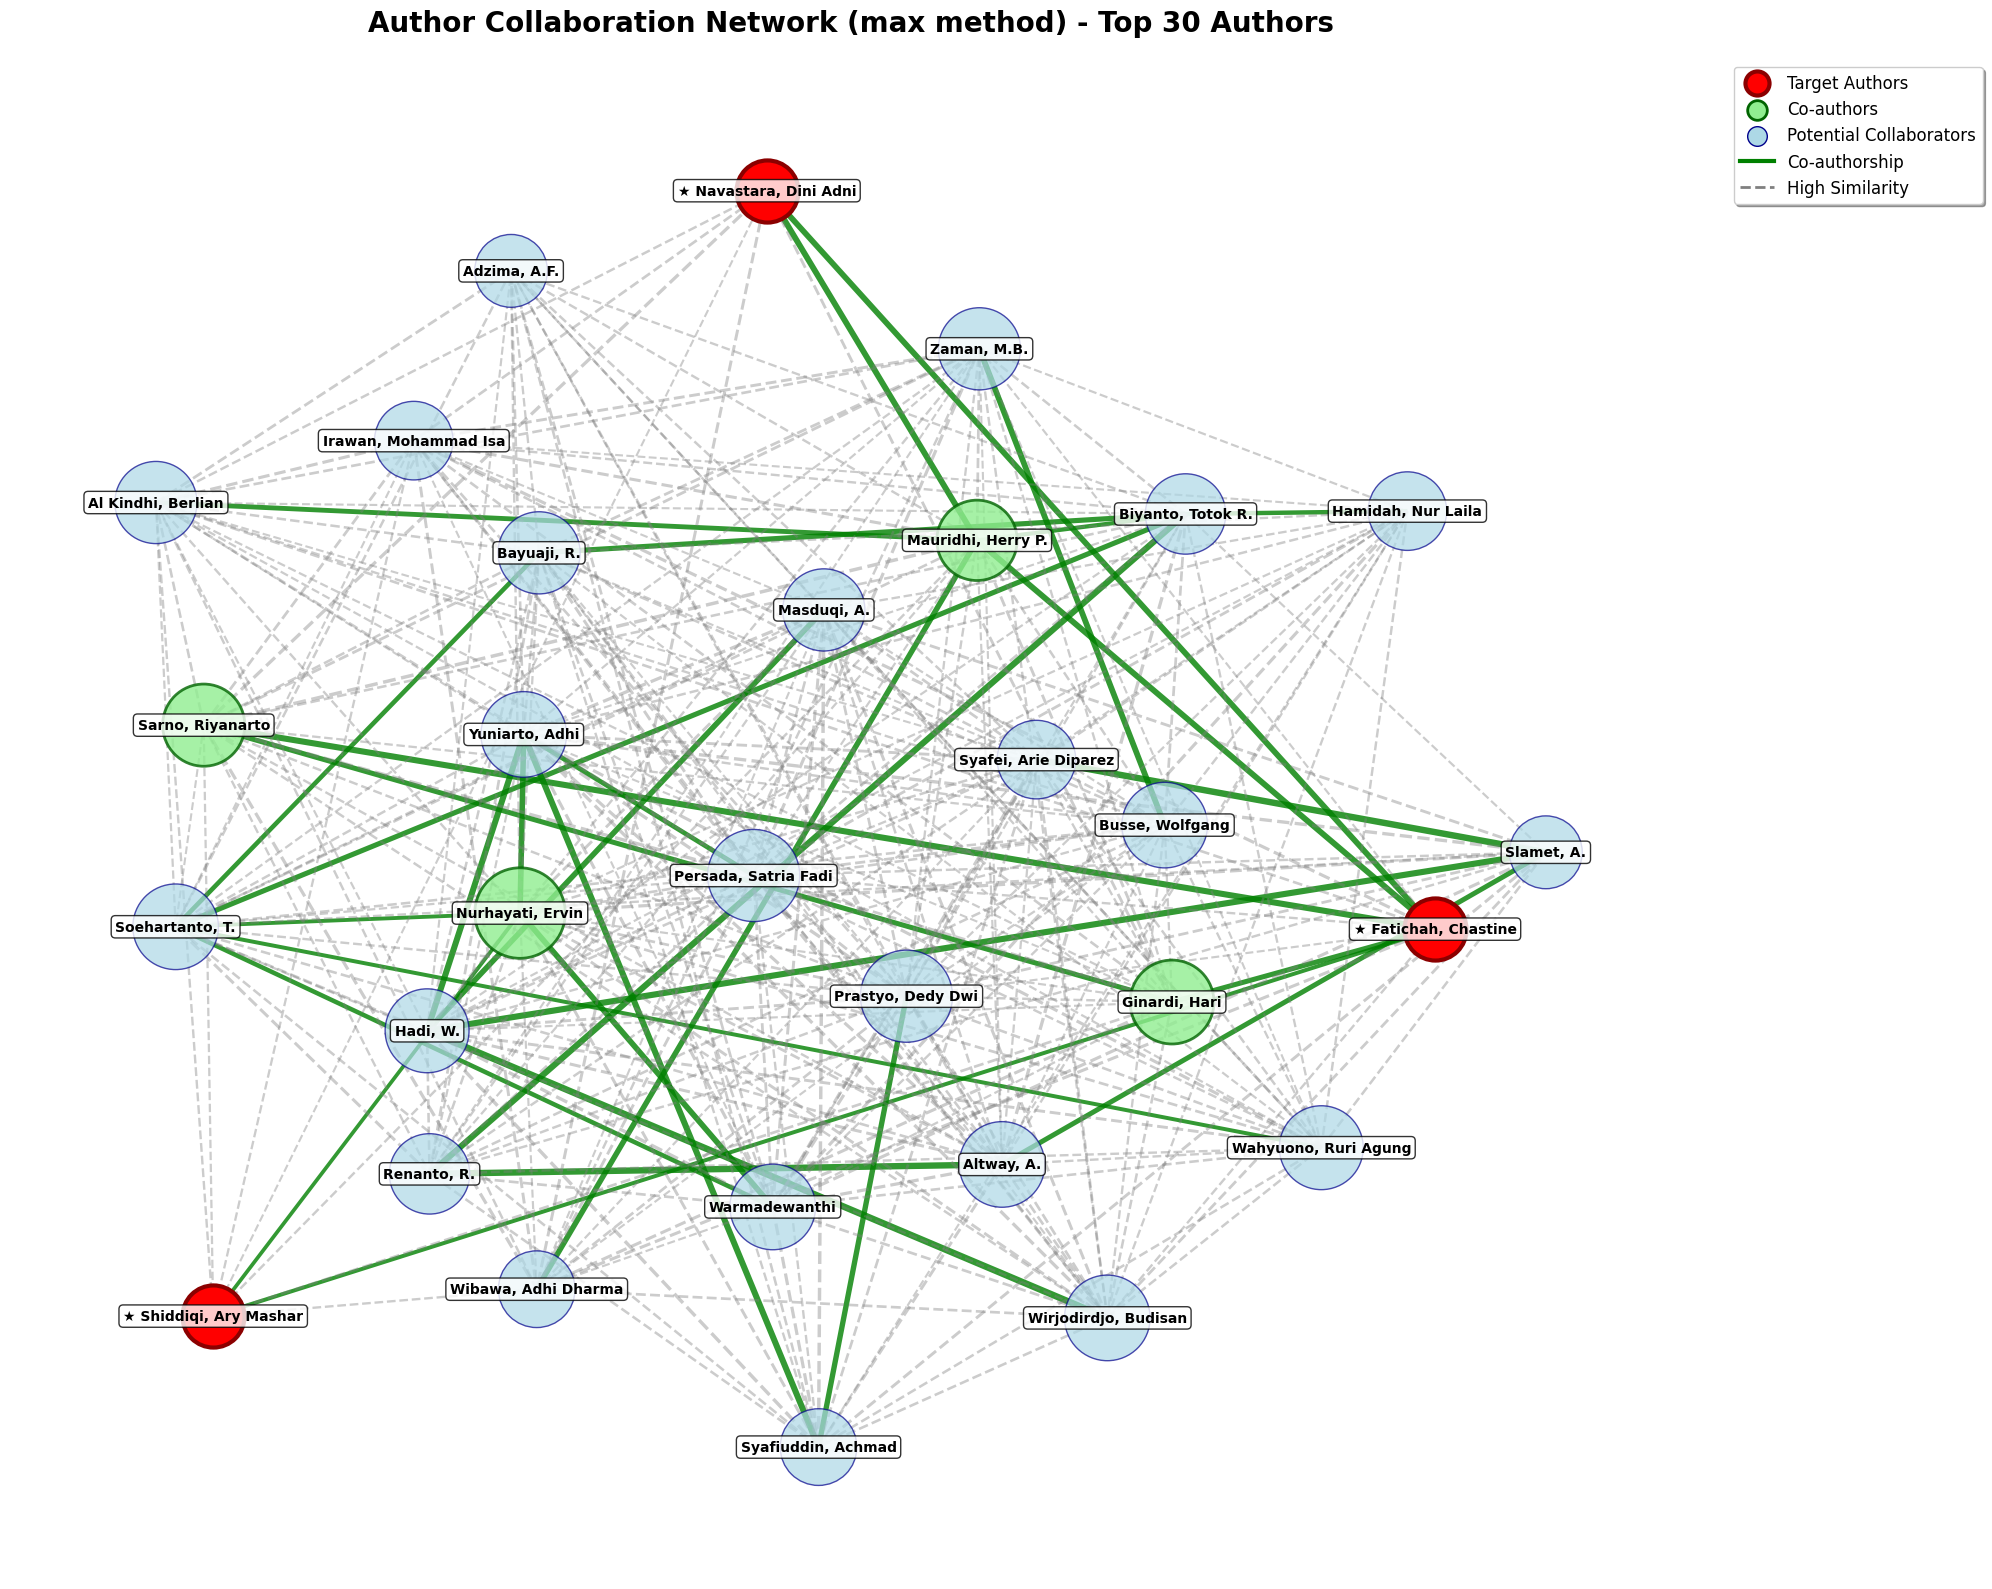

{'Navastara, Dini Adni': array([-0.03355717,  1.        ]),
 'Fatichah, Chastine': array([ 0.78568702, -0.14225431]),
 'Shiddiqi, Ary Mashar': array([-0.71229165, -0.74083695]),
 'Sarno, Riyanarto': array([-0.72392787,  0.17328889]),
 'Mauridhi, Herry P.': array([0.22411729, 0.45913919]),
 'Irawan, Mohammad Isa': array([-0.4663758 ,  0.61337181]),
 'Ginardi, Hari': array([ 0.46319887, -0.25502859]),
 'Wibawa, Adhi Dharma': array([-0.31564826, -0.69923451]),
 'Al Kindhi, Berlian': array([-0.78249539,  0.5176576 ]),
 'Prastyo, Dedy Dwi': array([ 0.13766623, -0.24599744]),
 'Wirjodirdjo, Budisan': array([ 0.38389246, -0.74362746]),
 'Persada, Satria Fadi': array([-0.04967664, -0.05931045]),
 'Zaman, M.B.': array([0.22707729, 0.75543326]),
 'Nurhayati, Ervin': array([-0.33613346, -0.11739875]),
 'Altway, A.': array([ 0.25480669, -0.50624607]),
 'Wahyuono, Ruri Agung': array([ 0.64626204, -0.48035494]),
 'Bayuaji, R.': array([-0.31280062,  0.43983322]),
 'Biyanto, Totok R.': array([0.479839

In [47]:
print("Creating Author Network Visualization")

G = create_author_network(
    similarity_threshold=0.5,
    max_authors=30,
    target_authors=target_author_ids
)

print(f"Network has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

plot_author_network(G, title=f"Author Collaboration Network ({agg_method} method) - Top 30 Authors")

In [48]:
def create_individual_author_graph(target_author_id, recs_df, top_k=20):
    G = nx.Graph()
    
    target_name = author_map.get(target_author_id, "Unknown")
    G.add_node(target_name, 
               node_type='target', 
               similarity=1.0,
               author_id=target_author_id)
    
    for idx, row in recs_df.head(top_k).iterrows():
        rec_name = row['author_name'][:30]
        similarity = row['similarity']
        is_coauthor = row['is_real_coauthor']
        
        node_type = 'coauthor' if is_coauthor else 'potential'
        G.add_node(rec_name, 
                   node_type=node_type, 
                   similarity=similarity,
                   author_id=row['author_id'],
                   keyword_overlap=row['keyword_overlap_count'])
        G.add_edge(target_name, rec_name, 
                   weight=similarity, 
                   is_coauthor=is_coauthor)
    
    return G

In [49]:
def create_circular_positions(G, target_name):
    pos = {}
    nodes = list(G.nodes())
    nodes.remove(target_name)
    
    nodes_sorted = sorted(nodes, 
                         key=lambda x: G.nodes[x]['similarity'], 
                         reverse=True)
    
    pos[target_name] = (0, 0)
    
    n = len(nodes_sorted)
    radius = 1.0
    
    for i, node in enumerate(nodes_sorted):
        angle = 2 * np.pi * i / n
        x = radius * np.cos(angle)
        y = radius * np.sin(angle)
        pos[node] = (x, y)
    
    return pos

In [50]:
def plot_individual_author_graph(G, target_name, figsize=(14, 14)):
    
    fig, ax = plt.subplots(figsize=figsize, facecolor='white')
    
    pos = create_circular_positions(G, target_name)
    
    colors = {
        'target': '#2C3E50',
        'coauthor': '#27AE60',  
        'potential': '#3498DB'
    }
    
    target_nodes = [n for n, d in G.nodes(data=True) if d['node_type'] == 'target']
    coauthor_nodes = [n for n, d in G.nodes(data=True) if d['node_type'] == 'coauthor']
    potential_nodes = [n for n, d in G.nodes(data=True) if d['node_type'] == 'potential']
    
    for u, v, d in G.edges(data=True):
        similarity = d['weight']
        is_coauthor = d['is_coauthor']
        
        if is_coauthor:
            edge_color = colors['coauthor']
            alpha = 0.6
            style = 'solid'
            width = similarity * 3
        else:
            edge_color = colors['potential'] 
            alpha = 0.4
            style = 'solid'
            width = similarity * 2
            
        nx.draw_networkx_edges(G, pos, [(u, v)],
                              width=width,
                              alpha=alpha,
                              edge_color=edge_color,
                              style=style)
    
    nx.draw_networkx_nodes(G, pos, nodelist=target_nodes,
                          node_color=colors['target'],
                          node_size=3000,
                          alpha=0.9)
    
    nx.draw_networkx_nodes(G, pos, nodelist=target_nodes,
                          node_color='white',
                          node_size=3200,
                          alpha=1.0)
    nx.draw_networkx_nodes(G, pos, nodelist=target_nodes,
                          node_color=colors['target'],
                          node_size=3000,
                          alpha=0.9)
    
    if coauthor_nodes:
        node_sizes = [1500 + G.nodes[node]['similarity'] * 1000 for node in coauthor_nodes]
        nx.draw_networkx_nodes(G, pos, nodelist=coauthor_nodes,
                              node_color=colors['coauthor'],
                              node_size=node_sizes,
                              alpha=0.8,
                              edgecolors='white',
                              linewidths=2)
    
    if potential_nodes:
        node_sizes = [1500 + G.nodes[node]['similarity'] * 1000 for node in potential_nodes]
        nx.draw_networkx_nodes(G, pos, nodelist=potential_nodes,
                              node_color=colors['potential'],
                              node_size=node_sizes,
                              alpha=0.8,
                              edgecolors='white',
                              linewidths=2)
    
    labels = {}
    label_pos = {}
    
    for node in G.nodes():
        labels[node] = node
        x, y = pos[node]
        
        if node == target_name:
            label_pos[node] = (x, y - 0.15)
        else:
            angle = np.arctan2(y, x)
            label_x = x + 0.15 * np.cos(angle)
            label_y = y + 0.15 * np.sin(angle)
            label_pos[node] = (label_x, label_y)
    
    target_label = {target_name: target_name}
    nx.draw_networkx_labels(G, label_pos, target_label,
                           font_size=14,
                           font_weight='bold',
                           font_family='sans-serif')
    
    other_labels = {n: n for n in G.nodes() if n != target_name}
    nx.draw_networkx_labels(G, label_pos, other_labels,
                           font_size=10,
                           font_family='sans-serif')
    
    plt.title(f'Author Recommendations for {target_name}\n{agg_method.capitalize()} Method | Top 20 with Similarity ≥ 0.5',
              fontsize=16,
              fontweight='bold',
              pad=20,
              fontfamily='sans-serif')
    
    legend_elements = [
        plt.scatter([], [], c=colors['target'], s=200, label='Target Author', edgecolors='white', linewidths=2),
        plt.scatter([], [], c=colors['coauthor'], s=150, label='Existing Co-author', edgecolors='white', linewidths=2),
        plt.scatter([], [], c=colors['potential'], s=150, label='Potential Collaborator', edgecolors='white', linewidths=2)
    ]
    
    plt.legend(handles=legend_elements, 
              loc='upper right',
              bbox_to_anchor=(1.15, 1),
              frameon=True,
              fancybox=True,
              shadow=True,
              fontsize=11)
    
    ax.set_xlim(-1.8, 1.8)
    ax.set_ylim(-1.8, 1.8)
    ax.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    stats = {
        'total_recommendations': len(G.nodes()) - 1,
        'coauthors': len(coauthor_nodes),
        'new_collaborators': len(potential_nodes),
        'avg_similarity': np.mean([G.nodes[n]['similarity'] for n in G.nodes() if n != target_name])
    }
    
    return stats

Individual Author Recommendation Graphs

Visualizing recommendations for: Navastara, Dini Adni
Found 20 authors with similarity ≥ 0.5


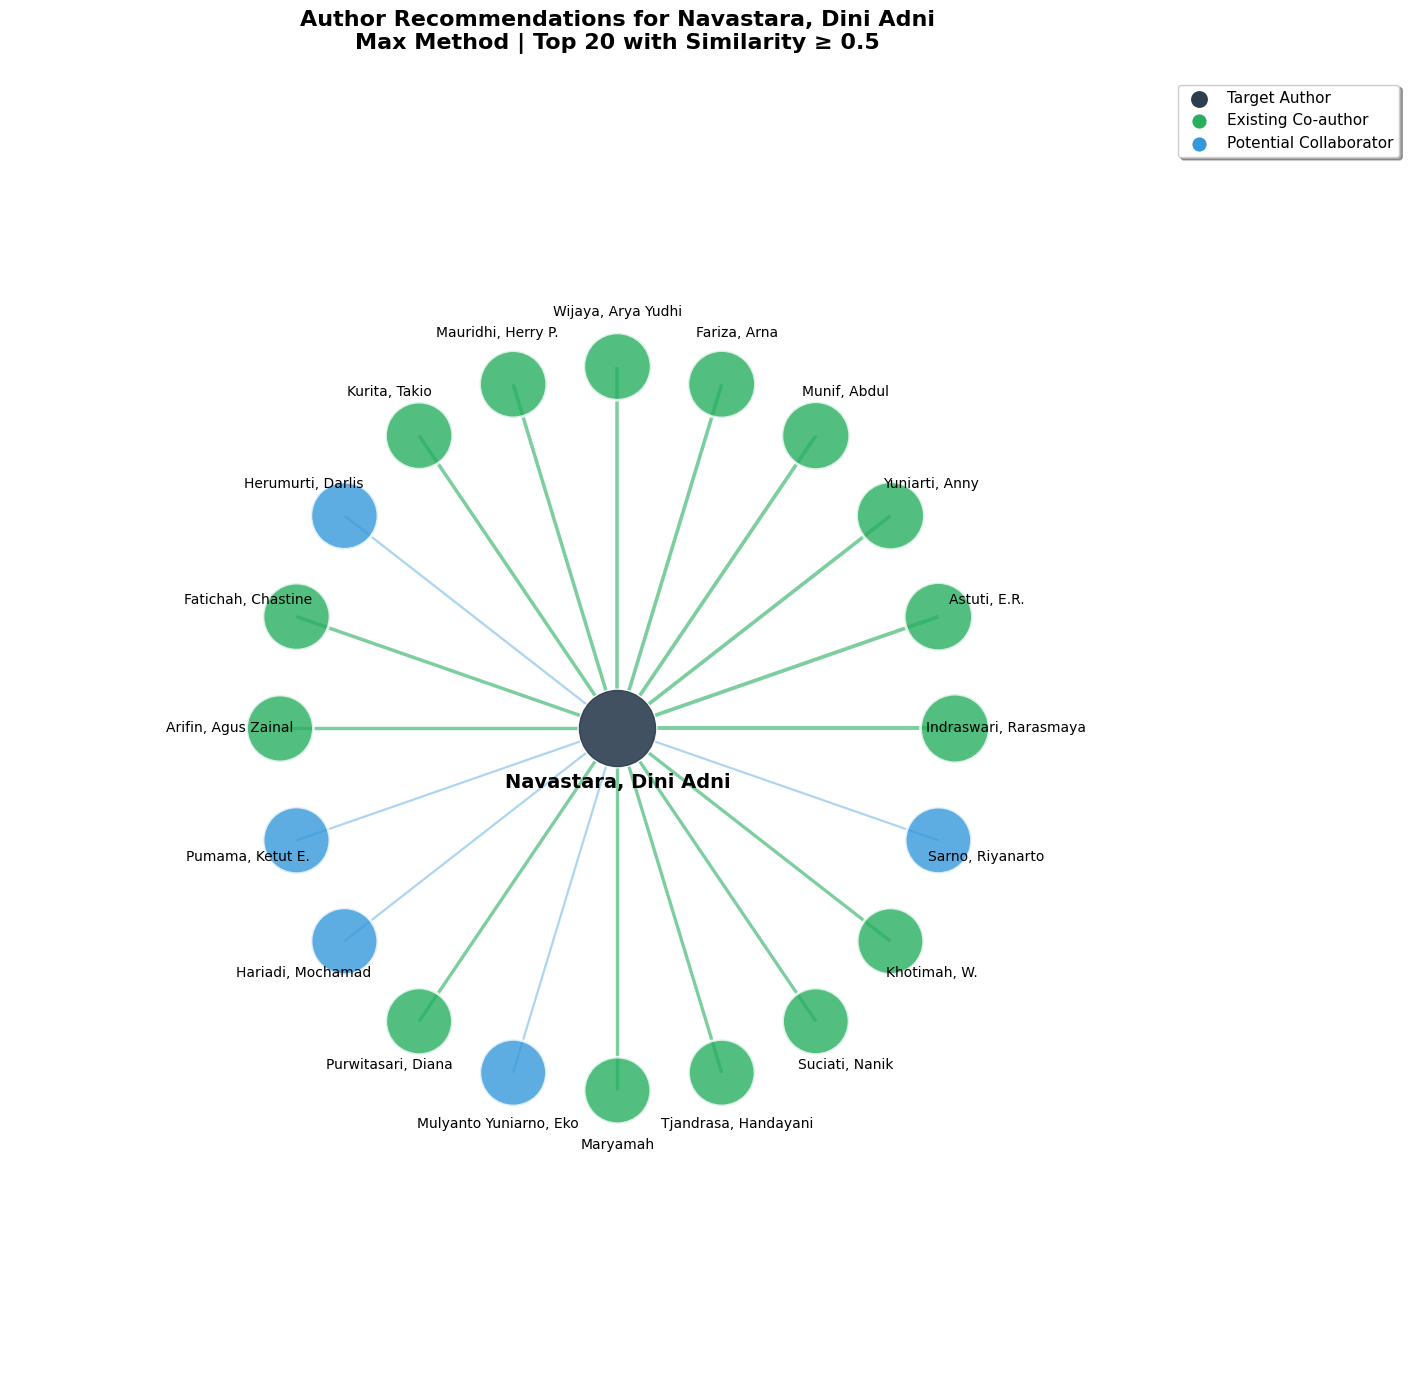


Visualization Statistics:
- Total shown: 20 authors
- Existing co-authors: 15
- New potential collaborators: 5
- Average similarity: 0.833

Top 5 Recommendations:
1. Indraswari, Rarasmaya [Co-author] - Sim: 0.947
   Keywords: image, segmentation, dental
2. Astuti, E.R. [Co-author] - Sim: 0.908
   Keywords: dental, segmentation, image
3. Yuniarti, Anny [Co-author] - Sim: 0.884
   Keywords: image, dental, segmentation
4. Munif, Abdul [Co-author] - Sim: 0.883
   Keywords: learning, detection, image
5. Fariza, Arna [Co-author] - Sim: 0.862
   Keywords: segmentation, image, dental
Visualizing recommendations for: Fatichah, Chastine
Found 20 authors with similarity ≥ 0.5


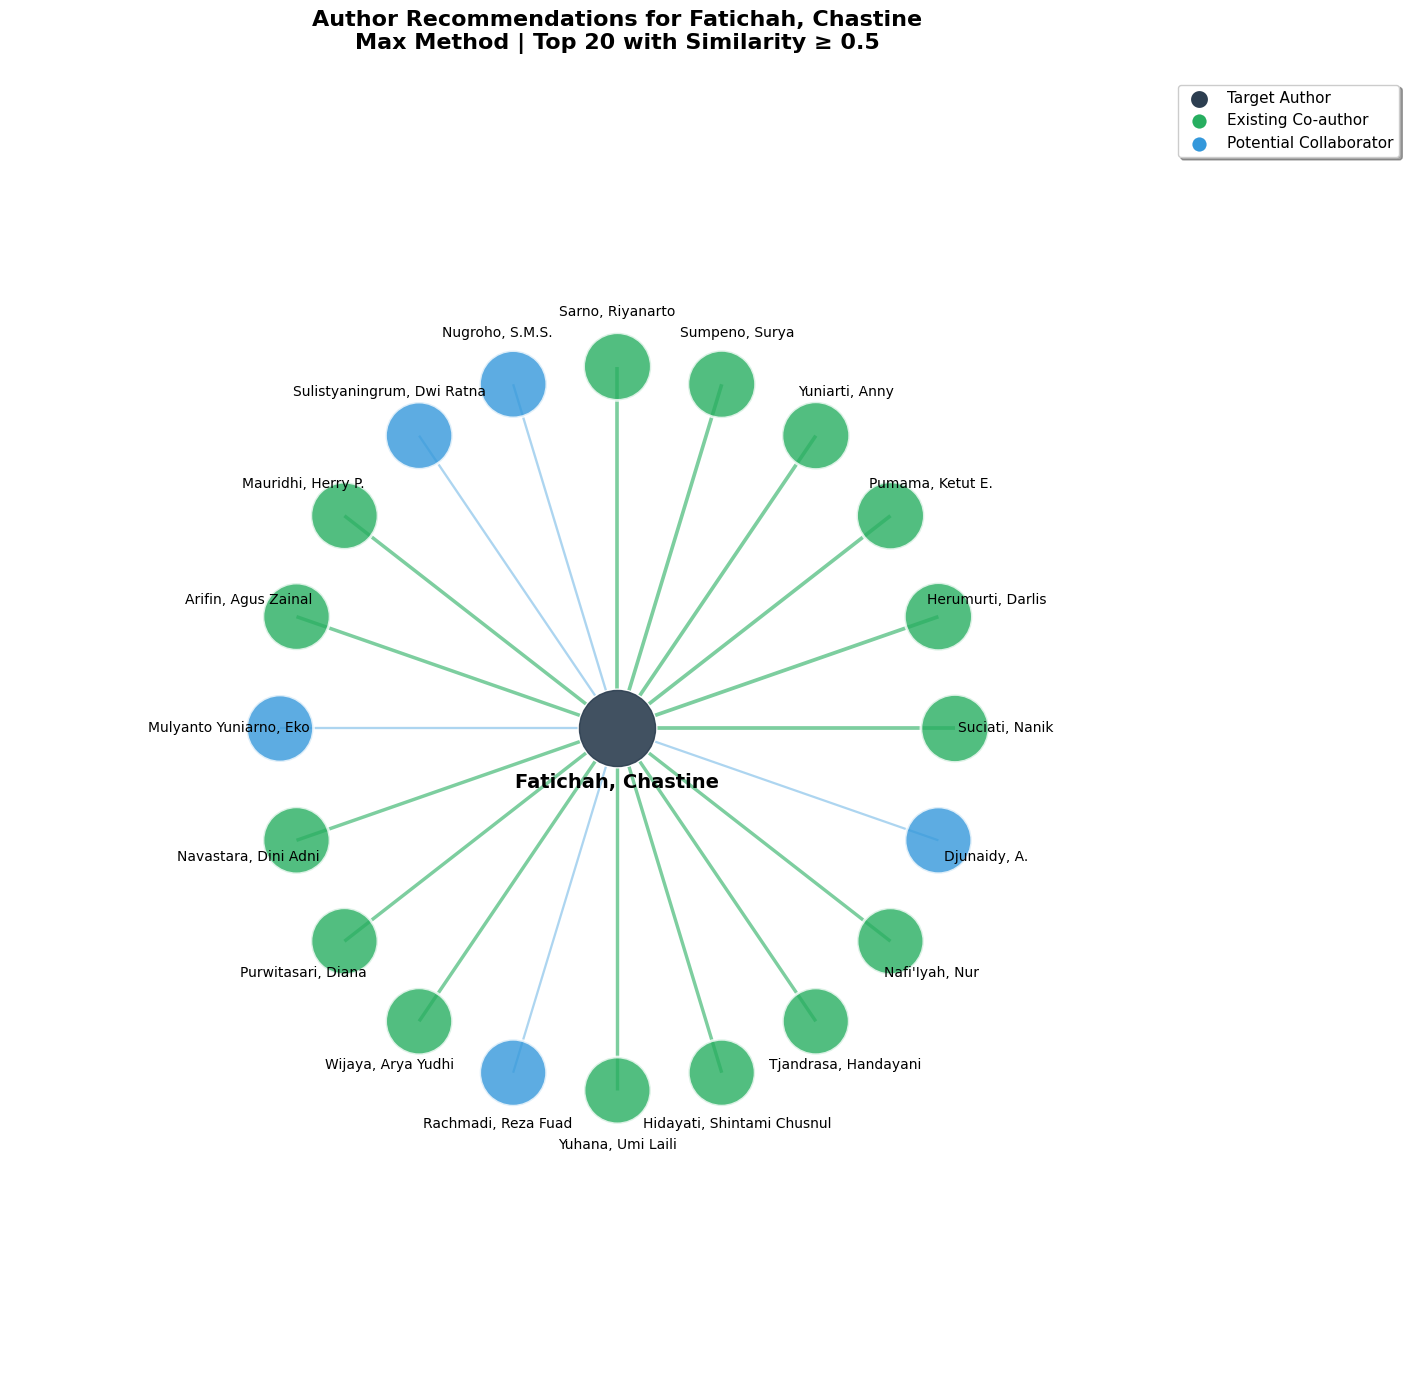


Visualization Statistics:
- Total shown: 20 authors
- Existing co-authors: 15
- New potential collaborators: 5
- Average similarity: 0.842

Top 5 Recommendations:
1. Suciati, Nanik [Co-author] - Sim: 0.896
   Keywords: image, segmentation, learning
2. Herumurti, Darlis [Co-author] - Sim: 0.896
   Keywords: image, segmentation, learning
3. Pumama, Ketut E. [Co-author] - Sim: 0.883
   Keywords: image, segmentation, classification
4. Yuniarti, Anny [Co-author] - Sim: 0.877
   Keywords: image, classification, learning
5. Sumpeno, Surya [Co-author] - Sim: 0.875
   Keywords: learning, classification, image
Visualizing recommendations for: Shiddiqi, Ary Masharuddin
Found 20 authors with similarity ≥ 0.5


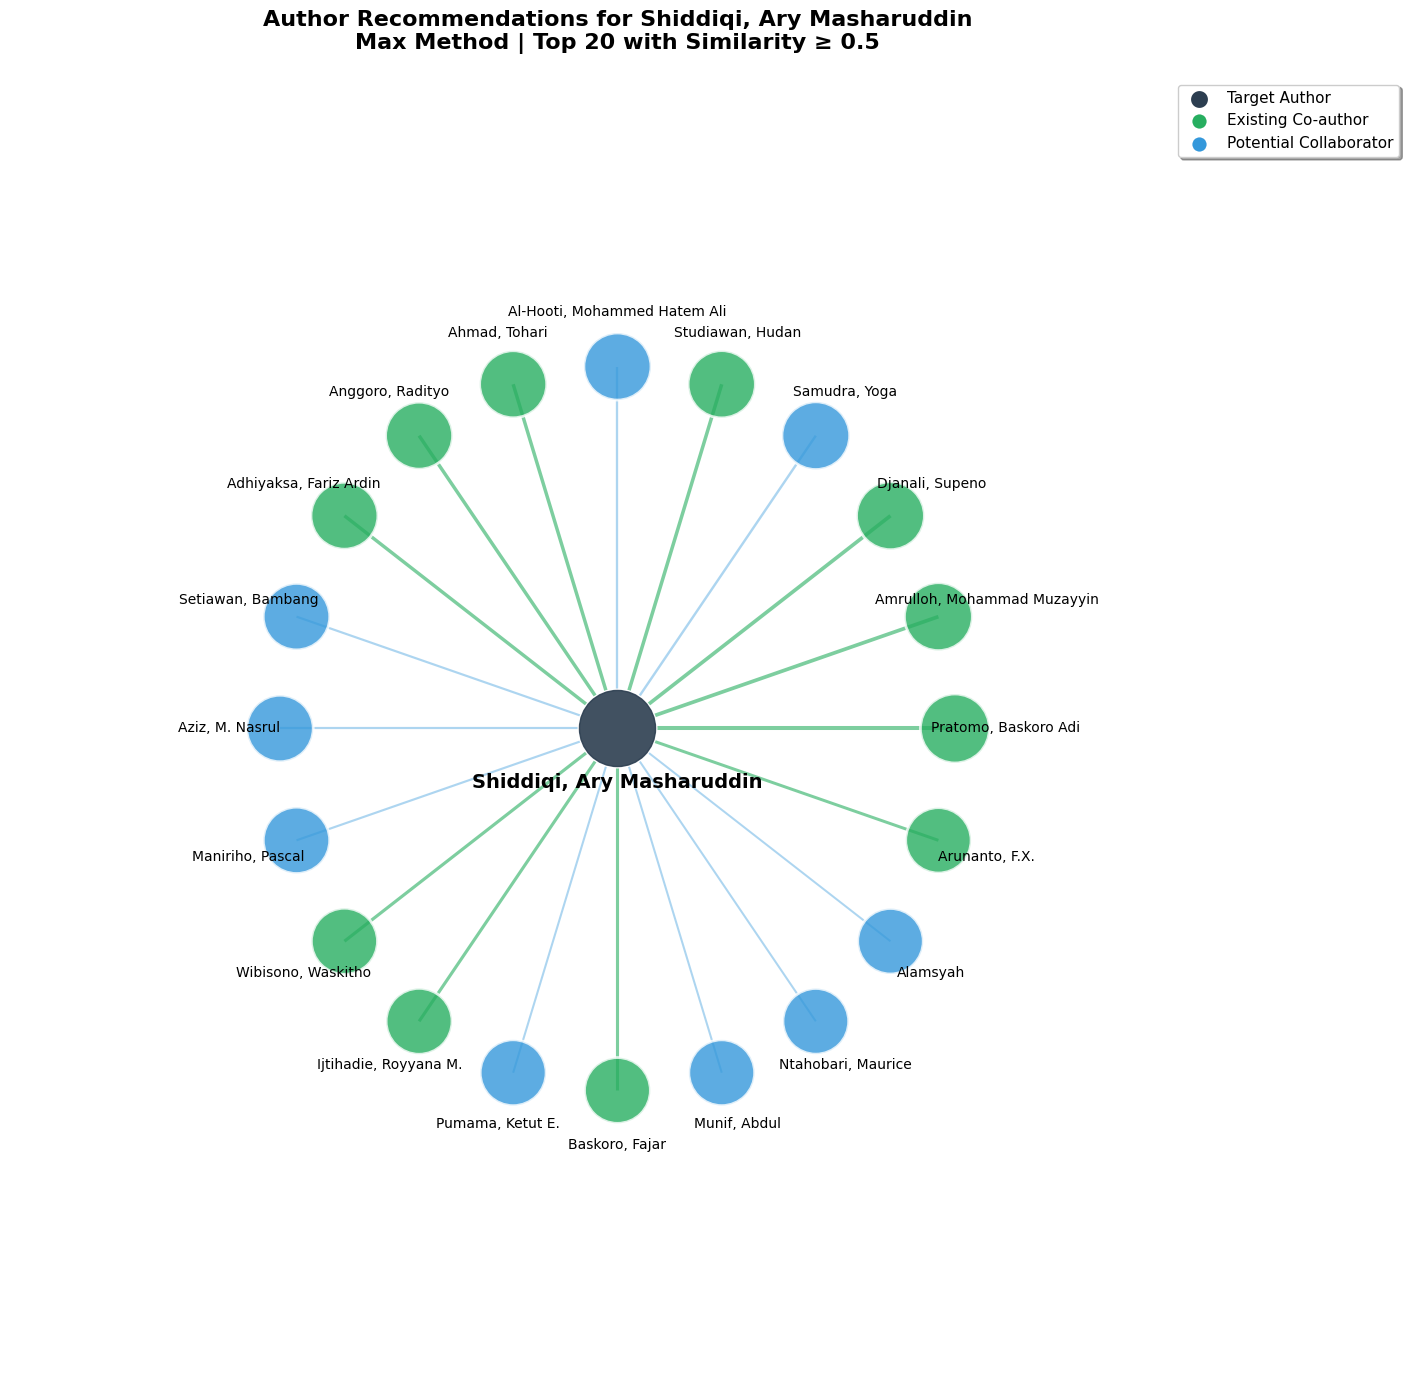


Visualization Statistics:
- Total shown: 20 authors
- Existing co-authors: 11
- New potential collaborators: 9
- Average similarity: 0.802

Top 5 Recommendations:
1. Pratomo, Baskoro Adi [Co-author] - Sim: 0.967
   Keywords: detection, intrusion, network
2. Amrulloh, Mohammad Muzayyin [Co-author] - Sim: 0.888
   Keywords: audio, hiding, data
3. Djanali, Supeno [Co-author] - Sim: 0.885
   Keywords: data, hiding, network
4. Samudra, Yoga [New] - Sim: 0.875
   Keywords: hiding, data, audio
5. Studiawan, Hudan [Co-author] - Sim: 0.843
   Keywords: detection, data, sensor


In [51]:
print("Individual Author Recommendation Graphs\n")

for target_author_id in target_author_ids:
    target_name = author_map.get(target_author_id, "Unknown")
    
    recs_df = recommend_authors(target_author_id, top_n=20, similarity_threshold=0.5)
    
    if recs_df is not None and len(recs_df) > 0:
        print(f"Visualizing recommendations for: {target_name}")
        print(f"Found {len(recs_df)} authors with similarity ≥ 0.5")
        
        G_individual = create_individual_author_graph(target_author_id, recs_df, top_k=20)
        stats = plot_individual_author_graph(G_individual, target_name)
        
        print(f"\nVisualization Statistics:")
        print(f"- Total shown: {stats['total_recommendations']} authors")
        print(f"- Existing co-authors: {stats['coauthors']}")
        print(f"- New potential collaborators: {stats['new_collaborators']}")
        print(f"- Average similarity: {stats['avg_similarity']:.3f}")
        
        print(f"\nTop 5 Recommendations:")
        for idx, row in recs_df.head(5).iterrows():
            status = "Co-author" if row['is_real_coauthor'] else "New"
            print(f"{idx+1}. {row['author_name']} [{status}] - Sim: {row['similarity']:.3f}")
            if row['top_shared_keywords']:
                keywords = [kw for kw, _ in row['top_shared_keywords'][:3]]
                print(f"   Keywords: {', '.join(keywords)}")
    else:
        print(f"\nNo recommendations found for {target_name} with similarity ≥ 0.5")